Name: Pavan Kusampudi

700#: 700762366

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
# ---- Toy corpus ----
toy_text = "hello\nhelp\nhelium\nhello hello help help"

# ---- Larger text ----
with open("corpus.txt", "r", encoding="utf-8") as f:
    large_text = f.read()

text = toy_text + "\n" + large_text
text

'hello\nhelp\nhelium\nhello hello help help\nALICE’S ADVENTURES IN WONDERLAND\nby Lewis Carroll\n\nCHAPTER I. Down the Rabbit-Hole\n\nAlice was beginning to get very tired of sitting by her sister on the\nbank, and of having nothing to do: once or twice she had peeped into the\nbook her sister was reading, but it had no pictures or conversations in\nit, “and what is the use of a book,” thought Alice “without pictures or\nconversations?”\n\nSo she was considering in her own mind (as well as she could, for the\nhot day made her feel very sleepy and stupid), whether the pleasure of\nmaking a daisy-chain would be worth the trouble of getting up and\npicking the daisies, when suddenly a White Rabbit with pink eyes ran\nclose by her.\n\nThere was nothing so very remarkable in that; nor did Alice think it so\nvery much out of the way to hear the Rabbit say to itself, “Oh dear! Oh\ndear! I shall be late!” (when she thought it over afterwards, it\noccurred to her that she ought to have wondered

In [4]:
chars = sorted(list(set(text)))
stoi = {c:i for i,c in enumerate(chars)}
itos = {i:c for c,i in stoi.items()}

vocab_size = len(chars)
print("Vocab size:", vocab_size)


Vocab size: 55


In [5]:
def encode(s):
    return torch.tensor([stoi[c] for c in s], dtype=torch.long)

def decode(indices):
    return ''.join([itos[i] for i in indices])


In [6]:
class CharDataset(Dataset):
    def __init__(self, data, seq_len=100):
        self.data = encode(data)
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.data) - self.seq_len - 1
    
    def __getitem__(self, idx):
        chunk = self.data[idx: idx+self.seq_len]
        target = self.data[idx+1: idx+self.seq_len+1]   # next char prediction
        return chunk, target


In [7]:
seq_len = 100
batch_size = 64

dataset = CharDataset(text, seq_len)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)


In [8]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, emb_size=128, hidden_size=256):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, emb_size)
        self.rnn = nn.GRU(emb_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x, h=None):
        x = self.embed(x)
        out, h = self.rnn(x, h)
        logits = self.fc(out)
        return logits, h


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CharRNN(vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [10]:
train_losses = []
val_losses = []

epochs = 10

for ep in range(epochs):
    model.train()
    total_loss = 0

    for X, Y in train_loader:
        X, Y = X.to(device), Y.to(device)
        
        logits, _ = model(X)
        loss = criterion(logits.reshape(-1, vocab_size), Y.reshape(-1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X, Y in val_loader:
            X, Y = X.to(device), Y.to(device)
            logits, _ = model(X)
            loss = criterion(logits.reshape(-1, vocab_size), Y.reshape(-1))
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))
    print(f"Epoch {ep+1}/{epochs}  Train={train_losses[-1]:.4f}  Val={val_losses[-1]:.4f}")


Epoch 1/10  Train=2.9995  Val=2.4992
Epoch 2/10  Train=2.2760  Val=2.0670
Epoch 3/10  Train=1.8743  Val=1.6704
Epoch 4/10  Train=1.4731  Val=1.2643
Epoch 5/10  Train=1.0757  Val=0.8824
Epoch 6/10  Train=0.7215  Val=0.5674
Epoch 7/10  Train=0.4503  Val=0.3485
Epoch 8/10  Train=0.2789  Val=0.2239
Epoch 9/10  Train=0.1871  Val=0.1622
Epoch 10/10  Train=0.1400  Val=0.1293


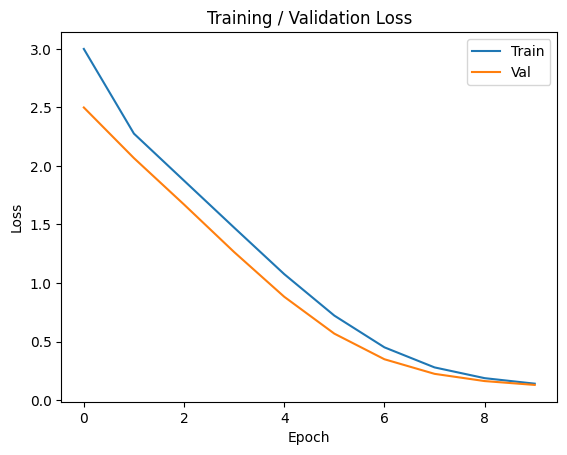

In [11]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training / Validation Loss")
plt.show()


In [12]:
def sample(model, start_text="h", length=300, temperature=1.0):
    model.eval()
    idx = encode(start_text).unsqueeze(0).to(device)
    h = None

    for _ in range(length):
        logits, h = model(idx[:, -1].unsqueeze(1), h)
        logits = logits[:, -1, :] / temperature
        prob = torch.softmax(logits, dim=-1)
        next_id = torch.multinomial(prob, 1)
        idx = torch.cat([idx, next_id], dim=1)

    return decode(idx[0].tolist())

print("τ=0.7:\n", sample(model, "h", 300, 0.7))
print("\nτ=1.0:\n", sample(model, "h", 300, 1.0))
print("\nτ=1.2:\n", sample(model, "h", 300, 1.2))


τ=0.7:
 he time
it all seemed when the Rabbit it, and burning with curiosity, she ran across the field
after it, and fortunately was just in time to see it pop down a lave world she was to get out of it, and burning with curiosity she ran across the field
after it, and fortunately was just in time to see it 

τ=1.0:
 hat pictures or conversations?”

So she was beginning to get very tring fo her feel very suddenly dowhen suddenly that AND
The world she was to get of it, and fortun
it, fnever for did Alice think it so
very much unel foe she founsting up and
picking the Rabbit actually took a watch uto the
by her si

τ=1.2:
 hen suddenly down, so suddenly momemed ilideely was nothing so very remarge
rabbit-hole ou.
dear! I… “whed at think it so
very much He it las hell
ao the way-consuddering in her forl seemyd be wrnturewar! and
picking the daight on like ar the Rabbit-Hole

Alice (as Whel very remarkable in that; nor n


### Reflection:

Increasing the sequence length allows the model to capture longer-range dependencies, improving coherence but also increasing training time and difficulty. A larger hidden size usually improves the model’s capacity to learn richer patterns, but it may overfit and requires more memory. During sampling, temperature strongly affects creativity: low τ (≈0.7) produces more repetitive and conservative text, τ = 1.0 gives balanced diversity, and high τ (1.2+) produces creative but often incoherent sequences. Teacher forcing helps the model converge faster by providing the correct previous character, but it can make sampling more brittle when the model must rely on its own predictions. Overall, the RNN learns meaningful character-level structure, but its generation quality is sensitive to these hyperparameters.